In [9]:
import numpy as np
import matplotlib.pyplot as plt

# ----- make nice figures -----
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 200
from cycler import cycler
COLORS = ['#F00D2C', '#242482', '#0071BE', '#4E8F00', '#553C67', '#DA5319']
default_cycler = cycler(color=COLORS)
plt.rc('axes', prop_cycle=default_cycler) 
# -----------------------------

In [2]:
data = np.loadtxt('data/perovskite_data.txt')

# Shuffle data
I_perm = np.random.permutation(len(data))
data = data[I_perm, :]

# Class data - whether we form Perovskite or not
c = data[:, 0]

# Extract all but the 0-th column
X = data[:, 1:]

# Normalize data
X = (X - np.mean(X, axis=0))/np.std(X, axis = 0)


In [3]:
# Training, validation and testing set
num_points = len(c)
num_train = int(0.8*0.8*num_points)
num_valid = int(0.8*0.2*num_points)
num_test = len(c) - num_train - num_valid

X_train = X[:num_train, :]
c_train = c[:num_train]

X_valid = X[num_train:(num_train + num_valid), :]
c_valid = c[num_train:(num_train + num_valid)]

# get the last "num_test" rows
X_test = X[-num_test:, :]
c_test = c[-num_test:]

print("         Total data size: " + str(num_points))
print("  Training data set size: " + str(num_train))
print("Validation data set size: " + str(num_valid))
print("   Testing data set size: " + str(num_test))

         Total data size: 355
  Training data set size: 227
Validation data set size: 56
   Testing data set size: 72


## Kernel SVM

In [5]:
from sklearn.svm import SVC
svm_model = SVC(kernel='poly', degree = 4, gamma = 'auto')
svm_model.fit(X_train, c_train)
c_model = svm_model.predict(X_valid)

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

score = f1_score(c_model, c_valid)
print("score " + str(score))

score 0.8709677419354839


Text(0, 0.5, 'F1 Score')

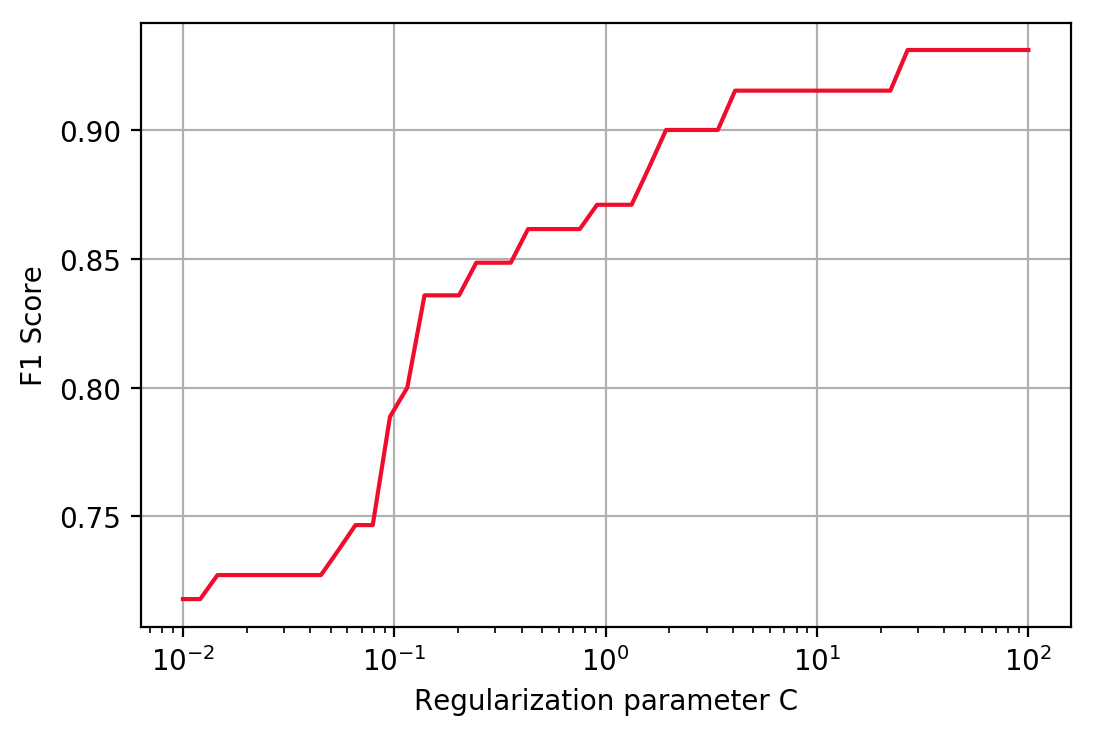

In [12]:
C_vals = np.logspace(-2, 2)
f1_scores = np.zeros(len(C_vals))

for i, C in enumerate(C_vals):
    svm_model = SVC(kernel='poly', degree = 4, gamma = 'auto', C = C)
    svm_model.fit(X_train, c_train)
    c_model = svm_model.predict(X_valid)
    f1_scores[i] = f1_score(c_model, c_valid)

plt.plot(C_vals, f1_scores)
plt.grid()
plt.xscale('log')
plt.xlabel('Regularization parameter C')
plt.ylabel('F1 Score')

In [13]:
i_best = np.argmax(f1_scores)
C_best = C_vals[i_best]
print(C_best)

# train final model
svm_model = SVC(kernel='poly', degree = 4, gamma = 'auto', C = C_best)
svm_model.fit(X_train, c_train)

# Predict accuracy on test data
c_model = svm_model.predict(X_test)
accuracy = accuracy_score(c_model, c_test)
f1 = f1_score(c_model, c_test)
print("Estimted accuracy for new data = " + str(100.0*accuracy) + "%")
print("Estimted f1 score for new data = " + str(100.0*f1) + "%")

26.826957952797247
Estimted accuracy for new data = 88.88888888888889%
Estimted f1 score for new data = 92.15686274509804%


# Classification Trees

Documentation:
http://www.scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [14]:
# Classification tree model
from sklearn.tree import DecisionTreeClassifier

# train with training data
model = DecisionTreeClassifier(criterion='entropy')
model.fit(X_train, c_train)

c_model = model.predict(X_valid)
score = accuracy_score(c_model, c_valid)
print(score)

0.9285714285714286


In [15]:
# Try a different "uniformity measure"
model = DecisionTreeClassifier(criterion='gini')
model.fit(X_train, c_train)
c_model = model.predict(X_valid)
score = accuracy_score(c_model, c_valid)
print(score)

0.9464285714285714


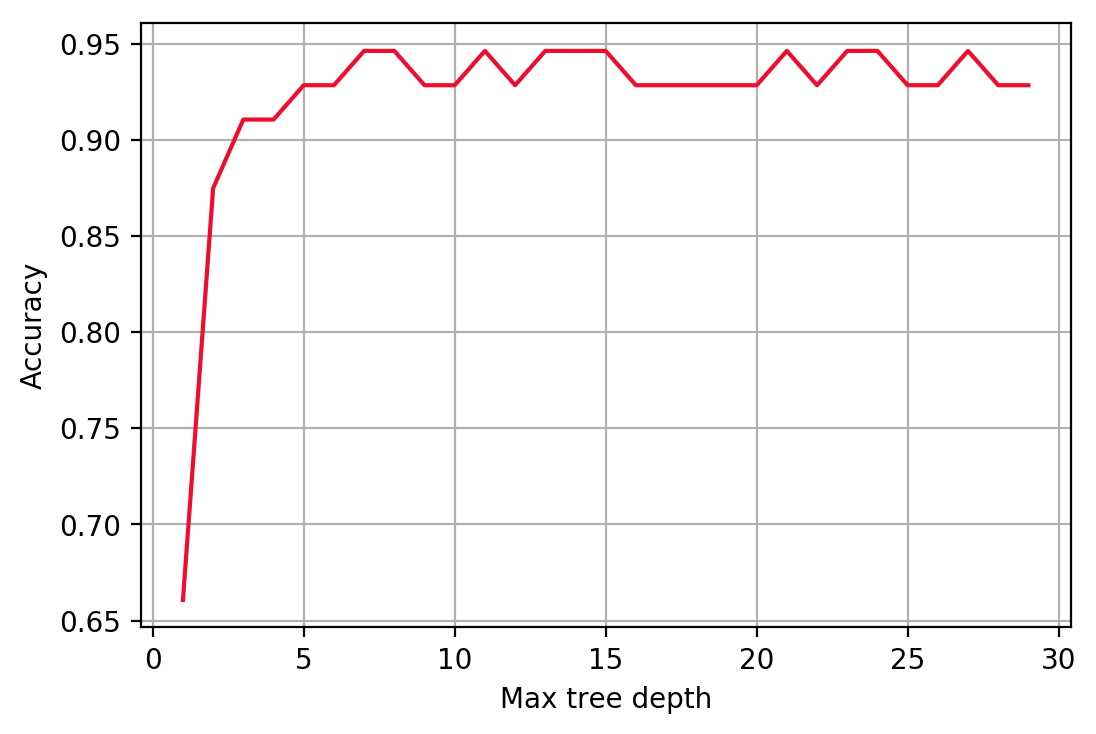

In [16]:
# Vary "max_depth"
depths = np.arange(1, 30)
scores = np.zeros(len(depths))

for i, d in enumerate(depths):
    model = DecisionTreeClassifier(criterion='gini', max_depth = d)
    model.fit(X_train, c_train)
    c_model = model.predict(X_valid)
    scores[i] = accuracy_score(c_model, c_valid)

plt.plot(depths, scores)
plt.xlabel('Max tree depth')
plt.ylabel('Accuracy')
plt.grid()

In [17]:
# Predict accuracy on test data
model = DecisionTreeClassifier(criterion='gini', max_depth = 6)
model.fit(X_train, c_train)
c_model = model.predict(X_test)
accuracy = accuracy_score(c_model, c_test)
f1 = f1_score(c_model, c_test)
print("Estimted accuracy for new data = " + str(100.0*accuracy) + "%")
print("Estimted f1 score for new data = " + str(100.0*f1) + "%")

Estimted accuracy for new data = 97.22222222222221%
Estimted f1 score for new data = 97.95918367346938%


# Analyzing the decision tree

In [ ]:
from sklearn.tree import plot_tree
plot_tree(model)

In [ ]:
feature_names = ["A-EN - O-EN", "rA/rO", "A-ionicity", "dA-O", "B-EN - O-EN", "rB/rO", "B-ionicity", "dB-O", "dA-O/dB-O", "A-EN - B-EN", "rA/rB", "t_BV", "t_IR", "GII"]
plot_tree(model, feature_names = feature_names )

## Feature importance

In [ ]:
importance = model.feature_importances_
print(importance)

In [ ]:
x_plot = [2*i for i in range(len(importance))]
plt.barh(x_plot, model.feature_importances_)
plt.yticks(x_plot, feature_names)
plt.grid(axis = 'x')
plt.xlabel('Importance')